In [2]:
import gdown
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pprint
import random
import pandas as pd
import pulp
import itertools
import requests
import random
from geopy.distance import geodesic
import time
import pandas as pd
import os

Downloading...
From (original): https://drive.google.com/uc?id=1zq17RENYLU1qrE2gNPsxRAPoysWMZAqf
From (redirected): https://drive.google.com/uc?id=1zq17RENYLU1qrE2gNPsxRAPoysWMZAqf&confirm=t&uuid=e5afa0d0-1015-41c7-896a-6e0deb2cb1d4
To: /content/mpsis_setup.py
100%|██████████| 12.1k/12.1k [00:00<00:00, 9.19MB/s]


Mounted at /content/drive


In [4]:
def generate_random_point(sw_lat, sw_lng, ne_lat, ne_lng):
    lat = random.uniform(sw_lat, ne_lat)
    lng = random.uniform(sw_lng, ne_lng)
    return lat, lng

def snap_to_road(lat, lng, api_key):
    url = f'https://roads.googleapis.com/v1/nearestRoads?points={lat},{lng}&key={api_key}'
    response = requests.get(url)
    data = response.json()
    if 'snappedPoints' in data and len(data['snappedPoints']) > 0:
        snapped_point = data['snappedPoints'][0]['location']
        return snapped_point['latitude'], snapped_point['longitude']
    return None

def get_road_distance_time(origin, destination, api_key):
    origin_str = f'{origin[0]}, {origin[1]}'
    destination_str = f'{destination[0]}, {destination[1]}'
    departure_time = int(time.time()) + 24 * 3600
    url = (
        f'https://maps.googleapis.com/maps/api/distancematrix/json?units=metric&origins={origin_str}'
        f'&destinations={destination_str}&mode=driving&departure_time={departure_time}&key={api_key}'
    )
    response = requests.get(url)
    data = response.json()

    if data['status'] == 'OK':
        element = data['rows'][0]['elements'][0]
        if element['status'] == 'OK':
            distance_text = element['distance']['text']
            distance = float(distance_text.replace(' km', '').replace(',', ''))

            duration_text = element['duration']['text']
            duration_parts = duration_text.split()
            duration = int(duration_parts[0])
            if "hour" in duration_text:
                duration = int(duration_parts[0]) * 60 + int(duration_parts[2])

            return distance, duration
        else:
            return None, None
    else:
        return None, None

def find_center(sw_lat, sw_lng, ne_lat, ne_lng):
    center_lat = (sw_lat + ne_lat) / 2
    center_lng = (sw_lng + ne_lng) / 2
    return center_lat, center_lng

def generate_list(n, target_sum):
    if n <= 1:
        raise ValueError("The length of the list must be greater than 1.")
    if target_sum < 0:
        raise ValueError("The target sum must be non-negative.")
    result = [0]
    random_values = np.random.rand(n - 1)
    random_values *= target_sum / np.sum(random_values)
    rounded_values = np.round(random_values, 2)
    difference = target_sum - np.sum(rounded_values)

    if len(rounded_values) > 0:
        rounded_values[-1] += difference

    result.extend(rounded_values)

    return result

def crop_matrix(data, N):
    return [row[:N] for row in data[:N]]

import numpy as np

def generate_demand_list(n, m, target_sum):
    if n <= 1:
        raise ValueError("The length of the list must be greater than 1.")
    if m >= n:
        raise ValueError("M must be less than N.")
    if target_sum < 0:
        raise ValueError("The target sum must be non-negative.")

    random_values = np.random.rand(n - m - 1)
    random_values *= target_sum / np.sum(random_values)
    rounded_values = np.round(random_values, 2)
    difference = target_sum - np.sum(rounded_values)

    if len(rounded_values) > 0:
        rounded_values[-1] += difference

    zeros_list = [0] * m

    result = list(rounded_values) + zeros_list

    random.shuffle(result)

    result = [-1] + result

    return result
def replace_zeros_with_sum(input_list, target_sum):
    zero_positions = [i for i, value in enumerate(input_list) if value == 0]
    num_zeros = len(zero_positions)

    result = input_list.copy()

    if num_zeros == 0:
        raise ValueError("There are no zeros to replace in the list.")

    random_values = np.random.rand(num_zeros)
    random_values *= target_sum / np.sum(random_values)
    rounded_values = np.round(random_values, 2)
    difference = target_sum - np.sum(rounded_values)

    if len(rounded_values) > 0:
        rounded_values[-1] += difference

    for i, pos in enumerate(zero_positions):
        result[pos] = rounded_values[i]

    return result

def create_path_as_list(pairs_list):
    wanted_length = len(pairs_list)
    path = ''
    current_pair = next(pair for pair in pairs_list if pair[0] == 0)
    path += str(current_pair[0])

    next_start = current_pair[1]

    pairs_list.remove(current_pair)

    while len(path) < wanted_length:
        path += str(next_start)
        current_pair = next(pair for pair in pairs_list if pair[0] == next_start)
        pairs_list.remove(current_pair)
        next_start = current_pair[1]

    return path

def find_paths_vrb(edges, k):
    def find_path_vrb(current_path):
        if len(paths) >= k:
            return

        last_node = current_path[-1]

        if last_node == 0 and len(current_path) > 1:
            paths.append(current_path)
            return

        for edge in edges:
            if edge[0] == last_node:
                find_path_vrb(current_path + [edge[1]])

    paths = []
    find_path_vrb([0])
    return paths

def repetitions(list1, list2):
  common_elements = set(list1) & set(list2)
  return (2*len(common_elements))/len(list1+list2)

def equal_paths(list1, list2):
  are_equal = sorted(list1) == sorted(list2)
  if are_equal:
    return 1
  else:
    return 0

In [6]:
def cvrp(number_of_clients, number_of_vehicles, cost_buffor, demand_of_client, file_idx, problem_idx):
    try:
        problem = pulp.LpProblem("CVRP", pulp.LpMinimize)

        cost_shiffted = crop_matrix(cost_buffor, number_of_clients + 1)
        capacity_of_vehicle = 100
        x = [[[pulp.LpVariable(f"x{i}_{j},{k}", cat="Binary") if i != j else None
              for k in range(number_of_vehicles)]
              for j in range(number_of_clients + 1)]
            for i in range(number_of_clients + 1)]

        u = pulp.LpVariable.dicts("u", range(1, number_of_clients + 1), 0, number_of_clients, cat="Continuous")

        problem += pulp.lpSum(cost_shiffted[i][j] * x[i][j][k] if i != j else 0
                              for k in range(number_of_vehicles)
                              for j in range(number_of_clients + 1)
                              for i in range(number_of_clients + 1))

        for j in range(1, number_of_clients + 1):
            problem += pulp.lpSum(x[i][j][k] if i != j else 0
                                  for i in range(number_of_clients + 1)
                                  for k in range(number_of_vehicles)) == 1

        for k in range(number_of_vehicles):
            problem += pulp.lpSum(x[0][j][k] for j in range(1, number_of_clients + 1)) == 1
            problem += pulp.lpSum(x[i][0][k] for i in range(1, number_of_clients + 1)) == 1

        for k in range(number_of_vehicles):
            for j in range(number_of_clients + 1):
                problem += pulp.lpSum(x[i][j][k] if i != j else 0
                                      for i in range(number_of_clients + 1)) - \
                          pulp.lpSum(x[j][i][k] for i in range(number_of_clients + 1)) == 0

        for k in range(number_of_vehicles):
            problem += pulp.lpSum(demand_of_client[j] * x[i][j][k] if i != j else 0
                                  for i in range(number_of_clients + 1)
                                  for j in range(1, number_of_clients + 1)) <= capacity_of_vehicle

        u = pulp.LpVariable.dicts("u", range(1, number_of_clients + 1), 0, number_of_clients, cat="Continuous")
        for i in range(1, number_of_clients + 1):
            for j in range(1, number_of_clients + 1):
                if i != j:
                    for k in range(number_of_vehicles):
                        problem += u[i] - u[j] + (number_of_clients * x[i][j][k]) <= number_of_clients - 1

        problem.solve()

        all_uesd_edges = []
        paths = [[] for _ in range(number_of_vehicles)]

        for k in range(number_of_vehicles):
            for i in range(number_of_clients + 1):
                for j in range(number_of_clients + 1):
                    if i != j and pulp.value(x[i][j][k]) == 1:
                        all_uesd_edges.append((i, j))
                        paths[k].append((i, j))

        result_paths = find_paths_vrb(all_uesd_edges, number_of_vehicles)
        return pulp.value(problem.objective)
    except Exception as e:
      print(f"error for delivery stops {number_of_clients} and vehicles {number_of_vehicles}")

      values_to_reload.append((number_of_clients, number_of_vehicles, file_idx, problem_idx))

      return None, None, None

In [22]:
def cvrp_cost_f(number_of_clients, number_of_vehicles, cost_buffor, demand_of_client, file_idx, problem_idx):
    try:
        problem = pulp.LpProblem("CVRP", pulp.LpMinimize)

        cost_shiffted = crop_matrix(cost_buffor, number_of_clients + 1)
        capacity_of_vehicle = 100
        x = [[[pulp.LpVariable(f"x{i}_{j},{k}", cat="Binary") if i != j else None
              for k in range(number_of_vehicles)]
              for j in range(number_of_clients + 1)]
            for i in range(number_of_clients + 1)]

        u = pulp.LpVariable.dicts("u", range(1, number_of_clients + 1), 0, number_of_clients, cat="Continuous")

        problem += pulp.lpSum(cost_shiffted[i][j] * x[i][j][k] if i != j else 0
                              for k in range(number_of_vehicles)
                              for j in range(number_of_clients + 1)
                              for i in range(number_of_clients + 1))


        for j in range(1, number_of_clients + 1):
            problem += pulp.lpSum(x[i][j][k] if i != j else 0
                                  for i in range(number_of_clients + 1)
                                  for k in range(number_of_vehicles)) == 1

        for k in range(number_of_vehicles):
            problem += pulp.lpSum(x[0][j][k] for j in range(1, number_of_clients + 1)) == 1
            problem += pulp.lpSum(x[i][0][k] for i in range(1, number_of_clients + 1)) == 1

        for k in range(number_of_vehicles):
            for j in range(number_of_clients + 1):
                problem += pulp.lpSum(x[i][j][k] if i != j else 0
                                      for i in range(number_of_clients + 1)) - \
                          pulp.lpSum(x[j][i][k] for i in range(number_of_clients + 1)) == 0

        for k in range(number_of_vehicles):
            problem += pulp.lpSum(demand_of_client[j] * x[i][j][k] if i != j else 0
                                  for i in range(number_of_clients + 1)
                                  for j in range(1, number_of_clients + 1)) <= capacity_of_vehicle

        u = pulp.LpVariable.dicts("u", range(1, number_of_clients + 1), 0, number_of_clients, cat="Continuous")
        for i in range(1, number_of_clients + 1):
            for j in range(1, number_of_clients + 1):
                if i != j:
                    for k in range(number_of_vehicles):
                        problem += u[i] - u[j] + (number_of_clients * x[i][j][k]) <= number_of_clients - 1

        for k in range(number_of_vehicles):
          problem += pulp.lpSum( x[i][j][k] * cost_shiffted[i][j] for j in range(number_of_clients + 1) for i in range(number_of_clients +1) if i != j) >= 1/number_of_vehicles * 3764
          problem += pulp.lpSum( x[i][j][k] * cost_shiffted[i][j] for j in range(number_of_clients +1) for i in range(number_of_clients +1) if i != j) <= 3764

        problem.solve()

        all_uesd_edges = []
        paths = [[] for _ in range(number_of_vehicles)]

        for k in range(number_of_vehicles):
            for i in range(number_of_clients + 1):
                for j in range(number_of_clients + 1):
                    if i != j and pulp.value(x[i][j][k]) == 1:
                        all_uesd_edges.append((i, j))
                        paths[k].append((i, j))

        result_paths = find_paths_vrb(all_uesd_edges, number_of_vehicles)
        return pulp.value(problem.objective)
    except Exception as e:
      print(f"error for delivery stops {number_of_clients} and vehicles {number_of_vehicles}")

      values_to_reload.append((number_of_clients, number_of_vehicles, file_idx, problem_idx))

      return None, None, None

In [19]:
def cvrp_stops(number_of_clients, number_of_vehicles, cost_buffor, demand_of_client, file_idx, problem_idx):
    try:
        problem = pulp.LpProblem("CVRP", pulp.LpMinimize)

        cost_shiffted = crop_matrix(cost_buffor, number_of_clients + 1)
        capacity_of_vehicle = 100
        x = [[[pulp.LpVariable(f"x{i}_{j},{k}", cat="Binary") if i != j else None
              for k in range(number_of_vehicles)]
              for j in range(number_of_clients + 1)]
            for i in range(number_of_clients + 1)]

        u = pulp.LpVariable.dicts("u", range(1, number_of_clients + 1), 0, number_of_clients, cat="Continuous")

        problem += pulp.lpSum(cost_shiffted[i][j] * x[i][j][k] if i != j else 0
                              for k in range(number_of_vehicles)
                              for j in range(number_of_clients + 1)
                              for i in range(number_of_clients + 1))


        for j in range(1, number_of_clients + 1):
            problem += pulp.lpSum(x[i][j][k] if i != j else 0
                                  for i in range(number_of_clients + 1)
                                  for k in range(number_of_vehicles)) == 1

        for k in range(number_of_vehicles):
            problem += pulp.lpSum(x[0][j][k] for j in range(1, number_of_clients + 1)) == 1
            problem += pulp.lpSum(x[i][0][k] for i in range(1, number_of_clients + 1)) == 1

        for k in range(number_of_vehicles):
            for j in range(number_of_clients + 1):
                problem += pulp.lpSum(x[i][j][k] if i != j else 0
                                      for i in range(number_of_clients + 1)) - \
                          pulp.lpSum(x[j][i][k] for i in range(number_of_clients + 1)) == 0

        for k in range(number_of_vehicles):
            problem += pulp.lpSum(demand_of_client[j] * x[i][j][k] if i != j else 0
                                  for i in range(number_of_clients + 1)
                                  for j in range(1, number_of_clients + 1)) <= capacity_of_vehicle

        u = pulp.LpVariable.dicts("u", range(1, number_of_clients + 1), 0, number_of_clients, cat="Continuous")
        for i in range(1, number_of_clients + 1):
            for j in range(1, number_of_clients + 1):
                if i != j:
                    for k in range(number_of_vehicles):
                        problem += u[i] - u[j] + (number_of_clients * x[i][j][k]) <= number_of_clients - 1


        for k in range(number_of_vehicles):
          problem += pulp.lpSum(x[i][j][k] for j in range(number_of_clients+1) for i in range(number_of_clients+1) if i != j) >= 4


        problem.solve()

        all_uesd_edges = []
        paths = [[] for _ in range(number_of_vehicles)]

        for k in range(number_of_vehicles):
            for i in range(number_of_clients + 1):
                for j in range(number_of_clients + 1):
                    if i != j and pulp.value(x[i][j][k]) == 1:
                        all_uesd_edges.append((i, j))
                        paths[k].append((i, j))

        result_paths = find_paths_vrb(all_uesd_edges, number_of_vehicles)
        return pulp.value(problem.objective)
    except Exception as e:
      print(f"error for delivery stops {number_of_clients} and vehicles {number_of_vehicles}")

      values_to_reload.append((number_of_clients, number_of_vehicles, file_idx, problem_idx))

      return None, None, None

In [9]:
def cvrp(number_of_clients, number_of_vehicles, cost_buffor, demand_of_client, file_idx, problem_idx):
    try:
        problem = pulp.LpProblem("CVRP", pulp.LpMinimize)

        cost_shiffted = crop_matrix(cost_buffor, number_of_clients + 1)
        capacity_of_vehicle = 100
        x = [[[pulp.LpVariable(f"x{i}_{j},{k}", cat="Binary") if i != j else None
              for k in range(number_of_vehicles)]
              for j in range(number_of_clients + 1)]
            for i in range(number_of_clients + 1)]

        u = pulp.LpVariable.dicts("u", range(1, number_of_clients + 1), 0, number_of_clients, cat="Continuous")

        problem += pulp.lpSum(cost_shiffted[i][j] * x[i][j][k] if i != j else 0
                              for k in range(number_of_vehicles)
                              for j in range(number_of_clients + 1)
                              for i in range(number_of_clients + 1))


        for j in range(1, number_of_clients + 1):
            problem += pulp.lpSum(x[i][j][k] if i != j else 0
                                  for i in range(number_of_clients + 1)
                                  for k in range(number_of_vehicles)) == 1

        for k in range(number_of_vehicles):
            problem += pulp.lpSum(x[0][j][k] for j in range(1, number_of_clients + 1)) == 1
            problem += pulp.lpSum(x[i][0][k] for i in range(1, number_of_clients + 1)) == 1

        for k in range(number_of_vehicles):
            for j in range(number_of_clients + 1):
                problem += pulp.lpSum(x[i][j][k] if i != j else 0
                                      for i in range(number_of_clients + 1)) - \
                          pulp.lpSum(x[j][i][k] for i in range(number_of_clients + 1)) == 0

        for k in range(number_of_vehicles):
            problem += pulp.lpSum(demand_of_client[j] * x[i][j][k] if i != j else 0
                                  for i in range(number_of_clients + 1)
                                  for j in range(1, number_of_clients + 1)) <= capacity_of_vehicle

        u = pulp.LpVariable.dicts("u", range(1, number_of_clients + 1), 0, number_of_clients, cat="Continuous")
        for i in range(1, number_of_clients + 1):
            for j in range(1, number_of_clients + 1):
                if i != j:
                    for k in range(number_of_vehicles):
                        problem += u[i] - u[j] + (number_of_clients * x[i][j][k]) <= number_of_clients - 1

        problem.solve()

        all_uesd_edges = []
        paths = [[] for _ in range(number_of_vehicles)]

        for k in range(number_of_vehicles):
            for i in range(number_of_clients + 1):
                for j in range(number_of_clients + 1):
                    if i != j and pulp.value(x[i][j][k]) == 1:
                        all_uesd_edges.append((i, j))
                        paths[k].append((i, j))

        result_paths = find_paths_vrb(all_uesd_edges, number_of_vehicles)
        return pulp.value(problem.objective)
    except Exception as e:
      print(f"error for delivery stops {number_of_clients} and vehicles {number_of_vehicles}")

      values_to_reload.append((number_of_clients, number_of_vehicles, file_idx, problem_idx))

      return None, None, None

In [10]:
def create_cost_matrixes(df):
    real_distance_columns = [col for col in df.columns if col.startswith('Road Distance to Point')]
    df_filtered = df[real_distance_columns]

    num_points = len(df_filtered)
    cost_raod = [[0] * num_points for _ in range(num_points)]

    for i in range(num_points):
        for j in range(num_points):
            if i != j:
                column_name = f'Road Distance to Point {j + 1}'
                distance = df_filtered.iloc[i][column_name]

                cost_raod[i][j] = float(distance)


    real_distance_columns = [col for col in df.columns if col.startswith('Time to Point')]
    df_filtered = df[real_distance_columns]

    num_points = len(df_filtered)
    cost_time = [[0] * num_points for _ in range(num_points)]

    for i in range(num_points):
        for j in range(num_points):
            if i != j:
                column_name = f'Time to Point {j + 1}'
                distance = df_filtered.iloc[i][column_name]

                cost_time[i][j] = float(distance)


    real_distance_columns = [col for col in df.columns if col.startswith('Real Distance to Point')]
    df_filtered = df[real_distance_columns]

    num_points = len(df_filtered)
    cost_real = [[0] * num_points for _ in range(num_points)]

    for i in range(num_points):
        for j in range(num_points):
            if i != j:
                column_name = f'Real Distance to Point {j + 1}'
                distance = df_filtered.iloc[i][column_name]

                cost_real[i][j] = float(distance)

    return cost_raod, cost_time, cost_real


In [11]:
import numpy as np
from scipy import stats

def confidence_interval_t(data, alpha=0.05):
    n = len(data)
    mean = np.mean(data)
    std_dev = np.std(data, ddof=1)
    t_critical = stats.t.ppf(1 - alpha/2, df=n-1)

    margin_of_error = t_critical * (std_dev / np.sqrt(n))

    return (margin_of_error)


### 10 CLIENTS CVRP 2 cracow

In [90]:
output_dir = 'X'
files = [f for f in os.listdir(output_dir) if f.startswith("X")]
print(files)

In [ ]:
output_2_cvrp_07 = []


for requested_file in files:
  print(f"############# calculated_file {requested_file}")
  file_idx = files.index(requested_file)
  df = pd.read_csv(os.path.join(output_dir, requested_file))
  df.fillna(10000000, inplace=True)
  cost_R, cost_T, cost_G = create_cost_matrixes(df)

  v_iterator = 0

  demand_of_client = generate_list(10 + 1, 0.7 * 100 * 2)

  output_2_cvrp_07.append(cvrp(10, 2, cost_R, demand_of_client, file_idx, "R"))

output_2_cvrp_07

############# calculated_file 30_clients_cracow_1
############# calculated_file 30_clients_cracow_2
############# calculated_file 30_clients_cracow_3.csv
############# calculated_file 30_clients_cracow_4.csv
############# calculated_file 30_clients_cracow_5.csv
############# calculated_file 30_clients_cracow_6.csv
############# calculated_file 30_clients_cracow_7.csv
############# calculated_file 30_clients_cracow_8.csv
############# calculated_file 30_clients_cracow_9.csv
############# calculated_file 30_clients_cracow_10.csv
############# calculated_file 30_clients_cracow_11.csv
############# calculated_file 30_clients_cracow_12.csv
############# calculated_file 30_clients_cracow_13.csv
############# calculated_file 30_clients_cracow_14.csv
############# calculated_file 30_clients_cracow_15.csv
############# calculated_file 30_clients_cracow_16.csv
############# calculated_file 30_clients_cracow_17.csv
############# calculated_file 30_clients_cracow_18.csv
############# calculated_fi

[51.49999999999999,
 41.6,
 37.39999999999999,
 35.2,
 55.1,
 50.199999999999996,
 34.099999999999994,
 49.699999999999996,
 61.89999999999999,
 28.700000000000003,
 57.900000000000006,
 43.2,
 30.0,
 47.5,
 29.599999999999998,
 33.599999999999994,
 60.10000000000001,
 51.9,
 55.0,
 33.699999999999996]

In [57]:
# [51.49999999999999,
#  41.6,
#  37.39999999999999,
#  35.2,
#  55.1,
#  50.199999999999996,
#  34.099999999999994,
#  49.699999999999996,
#  61.89999999999999,
#  28.700000000000003,
#  57.900000000000006,
#  43.2,
#  30.0,
#  47.5,
#  29.599999999999998,
#  33.599999999999994,
#  60.10000000000001,
#  51.9,
#  55.0,
#  33.699999999999996]
print(np.mean(output_2_cvrp_07))
print(confidence_interval_t(output_2_cvrp_07))

44.394999999999996
5.1412898639301945


In [ ]:
output_2_cvrp_00 = []


for requested_file in files:
  print(f"############# calculated_file {requested_file}")
  file_idx = files.index(requested_file)
  df = pd.read_csv(os.path.join(output_dir, requested_file))
  df.fillna(10000000, inplace=True)
  cost_R, cost_T, cost_G = create_cost_matrixes(df)

  v_iterator = 0

  demand_of_client = generate_list(10 + 1, 0 * 100 * 2)

  output_2_cvrp_00.append(cvrp(10, 2, cost_R, demand_of_client, file_idx, "R"))

output_2_cvrp_00

############# calculated_file 30_clients_cracow_1
############# calculated_file 30_clients_cracow_2
############# calculated_file 30_clients_cracow_3.csv
############# calculated_file 30_clients_cracow_4.csv
############# calculated_file 30_clients_cracow_5.csv
############# calculated_file 30_clients_cracow_6.csv
############# calculated_file 30_clients_cracow_7.csv
############# calculated_file 30_clients_cracow_8.csv
############# calculated_file 30_clients_cracow_9.csv
############# calculated_file 30_clients_cracow_10.csv
############# calculated_file 30_clients_cracow_11.csv
############# calculated_file 30_clients_cracow_12.csv
############# calculated_file 30_clients_cracow_13.csv
############# calculated_file 30_clients_cracow_14.csv
############# calculated_file 30_clients_cracow_15.csv
############# calculated_file 30_clients_cracow_16.csv
############# calculated_file 30_clients_cracow_17.csv
############# calculated_file 30_clients_cracow_18.csv
############# calculated_fi

[51.099999999999994,
 38.800000000000004,
 36.8,
 33.300000000000004,
 53.0,
 49.99999999999999,
 33.1,
 48.099999999999994,
 60.599999999999994,
 28.3,
 57.4,
 40.0,
 26.5,
 47.5,
 29.499999999999996,
 33.6,
 59.30000000000001,
 51.900000000000006,
 54.7,
 33.699999999999996]

In [ ]:
# [51.099999999999994,
#  38.800000000000004,
#  36.8,
#  33.300000000000004,
#  53.0,
#  49.99999999999999,
#  33.1,
#  48.099999999999994,
#  60.599999999999994,
#  28.3,
#  57.4,
#  40.0,
#  26.5,
#  47.5,
#  29.499999999999996,
#  33.6,
#  59.30000000000001,
#  51.900000000000006,
#  54.7,
#  33.699999999999996]
print(np.mean(output_2_cvrp_00))
print(confidence_interval_t(output_2_cvrp_00))

43.36
5.215797907864966


In [ ]:
output_2_cvrp_stops = []


for requested_file in files:
  print(f"############# calculated_file {requested_file}")
  file_idx = files.index(requested_file)
  df = pd.read_csv(os.path.join(output_dir, requested_file))
  df.fillna(10000000, inplace=True)
  cost_R, cost_T, cost_G = create_cost_matrixes(df)

  v_iterator = 0

  demand_of_client = generate_list(10 + 1, 0 * 100 * 2)

  output_2_cvrp_stops.append(cvrp_stops(10, 2, cost_R, demand_of_client, file_idx, "R"))

output_2_cvrp_stops

############# calculated_file 30_clients_cracow_1
############# calculated_file 30_clients_cracow_2
############# calculated_file 30_clients_cracow_3.csv
############# calculated_file 30_clients_cracow_4.csv
############# calculated_file 30_clients_cracow_5.csv
############# calculated_file 30_clients_cracow_6.csv
############# calculated_file 30_clients_cracow_7.csv
############# calculated_file 30_clients_cracow_8.csv
############# calculated_file 30_clients_cracow_9.csv
############# calculated_file 30_clients_cracow_10.csv
############# calculated_file 30_clients_cracow_11.csv
############# calculated_file 30_clients_cracow_12.csv
############# calculated_file 30_clients_cracow_13.csv
############# calculated_file 30_clients_cracow_14.csv
############# calculated_file 30_clients_cracow_15.csv
############# calculated_file 30_clients_cracow_16.csv
############# calculated_file 30_clients_cracow_17.csv
############# calculated_file 30_clients_cracow_18.csv
############# calculated_fi

[51.49999999999999,
 41.1,
 37.4,
 35.7,
 55.50000000000001,
 50.199999999999996,
 34.1,
 50.99999999999999,
 61.9,
 28.700000000000003,
 58.09999999999999,
 43.6,
 30.0,
 47.5,
 31.1,
 33.6,
 60.1,
 51.9,
 55.00000000000001,
 33.7]

In [ ]:
# [51.49999999999999,
#  41.1,
#  37.4,
#  35.7,
#  55.50000000000001,
#  50.199999999999996,
#  34.1,
#  50.99999999999999,
#  61.9,
#  28.700000000000003,
#  58.09999999999999,
#  43.6,
#  30.0,
#  47.5,
#  31.1,
#  33.6,
#  60.1,
#  51.9,
#  55.00000000000001,
#  33.7]
print(np.mean(output_2_cvrp_stops))
print(confidence_interval_t(output_2_cvrp_stops))

44.585
5.118925903681601


In [ ]:
output_2_cvrp_cost_f = []


for requested_file in files:
  print(f"############# calculated_file {requested_file}")
  file_idx = files.index(requested_file)
  df = pd.read_csv(os.path.join(output_dir, requested_file))
  df.fillna(10000000, inplace=True)
  cost_R, cost_T, cost_G = create_cost_matrixes(df)

  v_iterator = 0

  demand_of_client = generate_list(10 + 1, 0 * 100 * 2)

  output_2_cvrp_cost_f.append(cvrp_cost_f(10, 2, cost_R, demand_of_client, file_idx, "R"))

output_2_cvrp_cost_f

############# calculated_file 30_clients_cracow_1
############# calculated_file 30_clients_cracow_2
############# calculated_file 30_clients_cracow_3.csv
############# calculated_file 30_clients_cracow_4.csv
############# calculated_file 30_clients_cracow_5.csv
############# calculated_file 30_clients_cracow_6.csv
############# calculated_file 30_clients_cracow_7.csv
############# calculated_file 30_clients_cracow_8.csv
############# calculated_file 30_clients_cracow_9.csv
############# calculated_file 30_clients_cracow_10.csv
############# calculated_file 30_clients_cracow_11.csv
############# calculated_file 30_clients_cracow_12.csv
############# calculated_file 30_clients_cracow_13.csv
############# calculated_file 30_clients_cracow_14.csv
############# calculated_file 30_clients_cracow_15.csv
############# calculated_file 30_clients_cracow_16.csv
############# calculated_file 30_clients_cracow_17.csv
############# calculated_file 30_clients_cracow_18.csv
############# calculated_fi

[52.099999999999994,
 45.0,
 45.099999999999994,
 45.0,
 55.2,
 52.2,
 44.99999999999999,
 50.3,
 61.9,
 45.0,
 57.9,
 46.9,
 45.0,
 53.599999999999994,
 45.0,
 45.0,
 60.400000000000006,
 53.0,
 55.0,
 45.0]

In [ ]:
# [52.099999999999994,
#  45.0,
#  45.099999999999994,
#  45.0,
#  55.2,
#  52.2,
#  44.99999999999999,
#  50.3,
#  61.9,
#  45.0,
#  57.9,
#  46.9,
#  45.0,
#  53.599999999999994,
#  45.0,
#  45.0,
#  60.400000000000006,
#  53.0,
#  55.0,
#  45.0]
print(np.mean(output_2_cvrp_cost_f))
print(confidence_interval_t(output_2_cvrp_cost_f))

50.18
2.691734979345827


### 10 CLIENTS CVRP 2 europe

In [ ]:
output_dir = 'X'
files = [f for f in os.listdir(output_dir) if f.startswith("X")]
print(files)

In [15]:
output_2_cvrp_07 = []


for requested_file in files:
  print(f"############# calculated_file {requested_file}")
  file_idx = files.index(requested_file)
  df = pd.read_csv(os.path.join(output_dir, requested_file))
  df.fillna(10000000, inplace=True)
  cost_R, cost_T, cost_G = create_cost_matrixes(df)

  v_iterator = 0

  demand_of_client = generate_list(10 + 1, 0.7 * 100 * 2)

  output_2_cvrp_07.append(cvrp(10, 2, cost_R, demand_of_client, file_idx, "R"))

output_2_cvrp_07

############# calculated_file 30_clients_europe_1
############# calculated_file 30_clients_europe_2
############# calculated_file 30_clients_europe_3
############# calculated_file 30_clients_europe_5
############# calculated_file 30_clients_europe_7
############# calculated_file 30_clients_europe_8
############# calculated_file 30_clients_europe_6
############# calculated_file 30_clients_europe_9
############# calculated_file 30_clients_europe_10
############# calculated_file 30_clients_europe_11
############# calculated_file 30_clients_europe_12
############# calculated_file 30_clients_europe_13
############# calculated_file 30_clients_europe_14
############# calculated_file 30_clients_europe_15
############# calculated_file 30_clients_europe_16
############# calculated_file 30_clients_europe_17
############# calculated_file 30_clients_europe_18
############# calculated_file 30_clients_europe_19
############# calculated_file 30_clients_europe_20


[4126.9,
 3049.3,
 3753.0,
 4154.0,
 3620.1,
 3069.4,
 4420.2,
 4144.1,
 4898.0,
 3207.7,
 3821.8,
 3675.0,
 4024.4,
 3979.2,
 3077.8,
 3909.5,
 3732.6,
 3828.4,
 3555.1,
 3243.8]

In [58]:
# [4126.9,
#  3049.3,
#  3753.0,
#  4154.0,
#  3620.1,
#  3069.4,
#  4420.2,
#  4144.1,
#  4898.0,
#  3207.7,
#  3821.8,
#  3675.0,
#  4024.4,
#  3979.2,
#  3077.8,
#  3909.5,
#  3732.6,
#  3828.4,
#  3555.1,
#  3243.8]
print(np.mean(output_2_cvrp_07))
print(confidence_interval_t(output_2_cvrp_07))

44.394999999999996
5.1412898639301945


In [43]:
output_2_cvrp_00 = []


for requested_file in files:
  print(f"############# calculated_file {requested_file}")
  file_idx = files.index(requested_file)
  df = pd.read_csv(os.path.join(output_dir, requested_file))
  df.fillna(10000000, inplace=True)
  cost_R, cost_T, cost_G = create_cost_matrixes(df)

  v_iterator = 0

  demand_of_client = generate_list(10 + 1, 0 * 100 * 2)

  output_2_cvrp_00.append(cvrp(10, 2, cost_R, demand_of_client, file_idx, "R"))

output_2_cvrp_00

############# calculated_file 30_clients_europe_1
############# calculated_file 30_clients_europe_2
############# calculated_file 30_clients_europe_3
############# calculated_file 30_clients_europe_4
############# calculated_file 30_clients_europe_5
############# calculated_file 30_clients_europe_7
############# calculated_file 30_clients_europe_8
############# calculated_file 30_clients_europe_6
############# calculated_file 30_clients_europe_9
############# calculated_file 30_clients_europe_10
############# calculated_file 30_clients_europe_11
############# calculated_file 30_clients_europe_12
############# calculated_file 30_clients_europe_13
############# calculated_file 30_clients_europe_14
############# calculated_file 30_clients_europe_15
############# calculated_file 30_clients_europe_16
############# calculated_file 30_clients_europe_17
############# calculated_file 30_clients_europe_18
############# calculated_file 30_clients_europe_19
############# calculated_file 30_clients

[3835.9,
 3049.2999999999997,
 3391.0,
 3968.0,
 3332.1,
 2859.4,
 4049.4,
 3735.1,
 4898.0,
 2854.7,
 3642.8,
 3397.0,
 3746.4,
 3940.2,
 2959.7999999999997,
 3825.0,
 3573.0,
 3494.4,
 3050.1,
 2897.8]

In [44]:
# [3835.9,
#  3049.2999999999997,
#  3391.0,
#  3968.0,
#  3332.1,
#  2859.4,
#  4049.4,
#  3735.1,
#  4898.0,
#  2854.7,
#  3642.8,
#  3397.0,
#  3746.4,
#  3940.2,
#  2959.7999999999997,
#  3825.0,
#  3573.0,
#  3494.4,
#  3050.1,
#  2897.8]
print(np.mean(output_2_cvrp_00))
print(confidence_interval_t(output_2_cvrp_00))

3524.9700000000003
238.9848654270052


In [20]:
output_2_cvrp_stops = []


for requested_file in files:
  print(f"############# calculated_file {requested_file}")
  file_idx = files.index(requested_file)
  df = pd.read_csv(os.path.join(output_dir, requested_file))
  df.fillna(10000000, inplace=True)
  cost_R, cost_T, cost_G = create_cost_matrixes(df)

  v_iterator = 0

  demand_of_client = generate_list(10 + 1, 0 * 100 * 2)

  output_2_cvrp_stops.append(cvrp_stops(10, 2, cost_R, demand_of_client, file_idx, "R"))

output_2_cvrp_stops

############# calculated_file 30_clients_europe_1
############# calculated_file 30_clients_europe_2
############# calculated_file 30_clients_europe_3
############# calculated_file 30_clients_europe_4
############# calculated_file 30_clients_europe_5
############# calculated_file 30_clients_europe_7
############# calculated_file 30_clients_europe_8
############# calculated_file 30_clients_europe_6
############# calculated_file 30_clients_europe_9
############# calculated_file 30_clients_europe_10
############# calculated_file 30_clients_europe_11
############# calculated_file 30_clients_europe_12
############# calculated_file 30_clients_europe_13
############# calculated_file 30_clients_europe_14
############# calculated_file 30_clients_europe_15
############# calculated_file 30_clients_europe_16
############# calculated_file 30_clients_europe_17
############# calculated_file 30_clients_europe_18
############# calculated_file 30_clients_europe_19
############# calculated_file 30_clients

[4126.9,
 3049.2999999999997,
 3753.0,
 4154.0,
 3620.1000000000004,
 2949.4,
 4626.2,
 4144.1,
 5086.0,
 3207.7,
 3821.8,
 3675.0,
 4030.4,
 3979.2,
 3077.8,
 4175.5,
 3732.6,
 3706.4,
 3363.1,
 3243.8]

In [21]:
# [4126.9,
#  3049.2999999999997,
#  3753.0,
#  4154.0,
#  3620.1000000000004,
#  2949.4,
#  4626.2,
#  4144.1,
#  5086.0,
#  3207.7,
#  3821.8,
#  3675.0,
#  4030.4,
#  3979.2,
#  3077.8,
#  4175.5,
#  3732.6,
#  3706.4,
#  3363.1,
#  3243.8]
print(np.mean(output_2_cvrp_stops))
print(confidence_interval_t(output_2_cvrp_stops))

3776.1150000000002
254.660279790081


In [23]:
output_2_cvrp_cost_f = []


for requested_file in files:
  print(f"############# calculated_file {requested_file}")
  file_idx = files.index(requested_file)
  df = pd.read_csv(os.path.join(output_dir, requested_file))
  df.fillna(10000000, inplace=True)
  cost_R, cost_T, cost_G = create_cost_matrixes(df)

  v_iterator = 0

  demand_of_client = generate_list(10 + 1, 0 * 100 * 2)

  output_2_cvrp_cost_f.append(cvrp_cost_f(10, 2, cost_R, demand_of_client, file_idx, "R"))

output_2_cvrp_cost_f

############# calculated_file 30_clients_europe_1
############# calculated_file 30_clients_europe_2
############# calculated_file 30_clients_europe_3
############# calculated_file 30_clients_europe_4
############# calculated_file 30_clients_europe_5
############# calculated_file 30_clients_europe_7
############# calculated_file 30_clients_europe_8
############# calculated_file 30_clients_europe_6
############# calculated_file 30_clients_europe_9
############# calculated_file 30_clients_europe_10
############# calculated_file 30_clients_europe_11
############# calculated_file 30_clients_europe_12
############# calculated_file 30_clients_europe_13
############# calculated_file 30_clients_europe_14
############# calculated_file 30_clients_europe_15
############# calculated_file 30_clients_europe_16
############# calculated_file 30_clients_europe_17
############# calculated_file 30_clients_europe_18
############# calculated_file 30_clients_europe_19
############# calculated_file 30_clients

[4193.9,
 3828.2999999999997,
 4046.0,
 4154.0,
 3958.1,
 3777.3,
 4626.2,
 4255.1,
 5086.0,
 3836.7,
 3972.8,
 3998.0,
 4269.3,
 4028.2,
 3773.6,
 4625.5,
 4303.6,
 3974.4,
 3784.1,
 3807.8]

In [24]:
# [4193.9,
#  3828.2999999999997,
#  4046.0,
#  4154.0,
#  3958.1,
#  3777.3,
#  4626.2,
#  4255.1,
#  5086.0,
#  3836.7,
#  3972.8,
#  3998.0,
#  4269.3,
#  4028.2,
#  3773.6,
#  4625.5,
#  4303.6,
#  3974.4,
#  3784.1,
#  3807.8]
print(np.mean(output_2_cvrp_cost_f))
print(confidence_interval_t(output_2_cvrp_cost_f))

4114.945000000001
160.56121978625325


### 15 CLIENTS CVRP 2 cracow

In [92]:
output_dir = 'X'
files = [f for f in os.listdir(output_dir) if f.startswith("X")]
print(files)

In [ ]:
output_2_cvrp_07 = []


for requested_file in files:
  print(f"############# calculated_file {requested_file}")
  file_idx = files.index(requested_file)
  df = pd.read_csv(os.path.join(output_dir, requested_file))
  df.fillna(10000000, inplace=True)
  cost_R, cost_T, cost_G = create_cost_matrixes(df)

  v_iterator = 0

  demand_of_client = generate_list(15 + 1, 0.7 * 100 * 2)

  output_2_cvrp_07.append(cvrp(15, 2, cost_R, demand_of_client, file_idx, "R"))

In [60]:
# [60.900000000000006,
#  58.300000000000004,
#  65.0,
#  41.1,
#  49.3,
#  53.9,
#  46.2,
#  54.199999999999996,
#  63.89999999999999,
#  56.50000000000001,
#  67.8,
#  54.778,
#  56.199999999999996,
#  60.999999999999986,
#  52.4,
#  56.1,
#  68.3,
#  66.2,
#  67.69999999999999,
#  38.199999999999996]

print(np.mean(output_2_cvrp_07))
print(confidence_interval_t(output_2_cvrp_07))

56.898900000000005
4.039152361950374


In [ ]:
output_2_cvrp_00 = []


for requested_file in files:
  print(f"############# calculated_file {requested_file}")
  file_idx = files.index(requested_file)
  df = pd.read_csv(os.path.join(output_dir, requested_file))
  df.fillna(10000000, inplace=True)
  cost_R, cost_T, cost_G = create_cost_matrixes(df)

  v_iterator = 0

  demand_of_client = generate_list(15 + 1, 0 * 100 * 2)

  output_2_cvrp_00.append(cvrp(15, 2, cost_R, demand_of_client, file_idx, "R"))

In [61]:
# [60.000000000000014,
#  58.199999999999996,
#  64.60000000000001,
#  39.9,
#  47.699999999999996,
#  53.6,
#  46.199999999999996,
#  52.3,
#  61.89999999999999,
#  54.8,
#  66.89999999999999,
#  51.578,
#  53.79999999999999,
#  60.199999999999996,
#  52.400000000000006,
#  56.0,
#  67.69999999999999,
#  63.8,
#  67.4,
#  37.199999999999996]

print(np.mean(output_2_cvrp_00))
print(confidence_interval_t(output_2_cvrp_00))

55.80890000000001
4.058586284296022


In [ ]:
output_2_cvrp_stops = []


for requested_file in files:
  print(f"############# calculated_file {requested_file}")
  file_idx = files.index(requested_file)
  df = pd.read_csv(os.path.join(output_dir, requested_file))
  df.fillna(10000000, inplace=True)
  cost_R, cost_T, cost_G = create_cost_matrixes(df)

  v_iterator = 0

  demand_of_client = generate_list(15 + 1, 0 * 100 * 2)

  output_2_cvrp_stops.append(cvrp_stops(15, 2, cost_R, demand_of_client, file_idx, "R"))

In [63]:
# [60.90000000000001,
#  58.300000000000004,
#  65.0,
#  41.900000000000006,
#  49.300000000000004,
#  53.900000000000006,
#  46.199999999999996,
#  55.5,
#  63.899999999999984,
#  54.900000000000006,
#  68.2,
#  54.778000000000006,
#  56.39999999999999,
#  60.999999999999986,
#  52.4,
#  56.1,
#  68.49999999999999,
#  63.8,
#  68.0,
#  40.2]

print(np.mean(output_2_cvrp_stops))
print(confidence_interval_t(output_2_cvrp_stops))

56.95889999999999
3.869970376620473


In [ ]:
output_2_cvrp_cost_f = []


for requested_file in files:
  print(f"############# calculated_file {requested_file}")
  file_idx = files.index(requested_file)
  df = pd.read_csv(os.path.join(output_dir, requested_file))
  df.fillna(10000000, inplace=True)
  cost_R, cost_T, cost_G = create_cost_matrixes(df)

  v_iterator = 0

  demand_of_client = generate_list(15 + 1, 0 * 100 * 2)

  output_2_cvrp_cost_f.append(cvrp_cost_f(15, 2, cost_R, demand_of_client, file_idx, "R"))

In [68]:
# [65.6475832121236,
#  67.26817679251899,
#  58.07709746586681,
#  50.14158501414372,
#  61.996705554770145,
#  65.65775874375274,
#  73.45482574816872,
#  73.25218660634607,
#  61.710545882728034,
#  62.327840414550934,
#  56.90989001605611,
#  54.21296778461513,
#  52.134709741253296,
#  78.6857126146004,
#  60.822435241522584,
#  61.34210732562989,
#  55.427042649586156,
#  70.16738990819559,
#  52.80535447034183,
#  62.97808481322761
# ]

print(np.mean(output_2_cvrp_cost_f))
print(confidence_interval_t(output_2_cvrp_cost_f))

62.250999999999934
3.604041405605295


### 15 CLIENTS CVRP 2 europe

In [89]:
output_dir = 'X'
files = [f for f in os.listdir(output_dir) if f.startswith("X")]
print(files)

In [ ]:
output_2_cvrp_07 = []

for requested_file in files:
  print(f"############# calculated_file {requested_file}")
  file_idx = files.index(requested_file)
  df = pd.read_csv(os.path.join(output_dir, requested_file))
  df.fillna(10000000, inplace=True)
  cost_R, cost_T, cost_G = create_cost_matrixes(df)

  v_iterator = 0

  demand_of_client = generate_list(15 + 1, 0.7 * 100 * 2)

  output_2_cvrp_07.append(cvrp(15, 2, cost_R, demand_of_client, file_idx, "R"))

In [80]:
# [4618.0,
#  4215.7,
#  3570.5,
#  4986.7,
#  4410.799999999999,
#  4857.200000000001,
#  4388.3, 4889.0,
#  5270.599999999999,
#  3036.6000000000004,
#  4755.8,
#  5267.0,
#  4902.3,
#  4425.2,
#  3851.3,
#  4505.8,
#  4549.7,
#  4461.4,
#  3471.2,
#  3790.4]

print(np.mean(output_2_cvrp_07))
print(confidence_interval_t(output_2_cvrp_07))

4411.174999999998
281.63753553828116


In [ ]:
output_2_cvrp_00 = []


for requested_file in files:
  print(f"############# calculated_file {requested_file}")
  file_idx = files.index(requested_file)
  df = pd.read_csv(os.path.join(output_dir, requested_file))
  df.fillna(10000000, inplace=True)
  cost_R, cost_T, cost_G = create_cost_matrixes(df)

  v_iterator = 0

  demand_of_client = generate_list(15 + 1, 0 * 100 * 2)

  output_2_cvrp_00.append(cvrp(15, 2, cost_R, demand_of_client, file_idx, "R"))

In [85]:
# [4445.1,
#  4137.3,
#  4261.0,
#  4618.0,
#  3845.0,
#  3495.5,
#  4561.9,
#  4340.799999999999,
#  5213.6,
#  3036.6,
#  4502.8,
#  4809.0,
#  4122.4,
#  3928.2,
#  3636.3,
#  4295.3,
#  4072.1,
#  4194.4,
#  3315.2000000000003,
#  3332.999999999999]

print(np.mean(output_2_cvrp_00))
print(confidence_interval_t(output_2_cvrp_00))

4108.174999999999
255.17223819805957


In [ ]:
output_2_cvrp_stops = []


for requested_file in files:
  print(f"############# calculated_file {requested_file}")
  file_idx = files.index(requested_file)
  df = pd.read_csv(os.path.join(output_dir, requested_file))
  df.fillna(10000000, inplace=True)
  cost_R, cost_T, cost_G = create_cost_matrixes(df)

  v_iterator = 0

  demand_of_client = generate_list(15 + 1, 0 * 100 * 2)

  output_2_cvrp_stops.append(cvrp_stops(15, 2, cost_R, demand_of_client, file_idx, "R"))

  output_2_cvrp_00.append(cvrp(15, 2, cost_R, demand_of_client, file_idx, "R"))

In [86]:
# [
#  4618.0,
#  4270.700000000001,
#  3740.5,
#  5140.7,
#  4864.8,
#  4857.200000000001,
#  4388.3,
#  4952.0,
#  4618.0,
#  4270.700000000001,
#  3740.5,
#  5140.7,
#  4864.8,
#  5270.6,
#  3619.6,
#  4826.8,
#  5267.0,
#  4902.3,
#  4405.2,
#  3901.2999999999997,
#  4505.8,
#  4549.7,
#  4580.4,
#  3720.1000000000004,
#  4059.3999999999996]

print(np.mean(output_2_cvrp_stops))
print(confidence_interval_t(output_2_cvrp_stops))

4523.004
208.26651845248105


In [ ]:
output_2_cvrp_cost_f = []


for requested_file in files:
  print(f"############# calculated_file {requested_file}")
  file_idx = files.index(requested_file)
  df = pd.read_csv(os.path.join(output_dir, requested_file))
  df.fillna(10000000, inplace=True)
  cost_R, cost_T, cost_G = create_cost_matrixes(df)

  v_iterator = 0

  demand_of_client = generate_list(15 + 1, 0 * 100 * 2)

  output_2_cvrp_cost_f.append(cvrp_cost_f(15, 2, cost_R, demand_of_client, file_idx, "R"))

In [84]:
# [4885.200000000001,
#   4802.3,
#   4980.0,
#   4713.2,
#   5066.9,
#   5274.7,
#   4604.6,
#   5211.4,
#   5075.1,
#   5195.4,
#   4947.6,
#   5428.4,
#   4683.1,
#   4903.1,
#   4659.6,
#   4946.300000000001,
#   4289.8,
#   5540.8,
#   4172.400000000001,
#   4301.7
# ]

print(np.mean(output_2_cvrp_cost_f))
print(confidence_interval_t(output_2_cvrp_cost_f))

4884.08
172.30085274262873


### WYKRESY

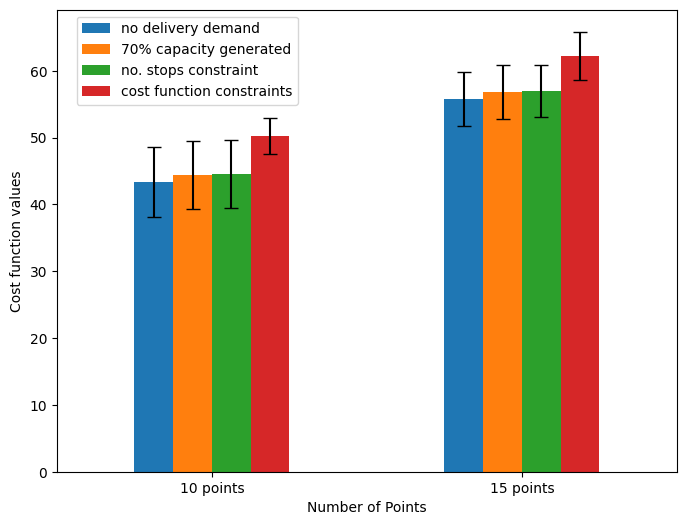

In [99]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

data = {
    'number of points': ['10 points', '15 points'],
    'no delivery demand': [43.36, 55.80890000000001],
    '70% capacity generated': [44.394999999999996,56.898900000000005],
    'no. stops constraint': [44.585,56.958899999999991],
    'cost function constraints': [50.18,62.250999999999934]
}

df = pd.DataFrame(data)

error_data = {
    'no delivery demand': [5.215797907864966, 4.058586284296022],
    '70% capacity generated': [5.1412898639301945, 4.039152361950374],
    'no. stops constraint': [5.118925903681601, 3.869970376620473],
    'cost function constraints': [2.691734979345827, 3.604041405605295]
}

errors_df = pd.DataFrame(error_data)

fig, ax = plt.subplots(figsize=(8, 6))
plt.grid()

df_plot = df.set_index(['number of points'])

df_plot.plot(kind='bar', yerr=errors_df.values.T, ax=ax, capsize=5)

ax.set_ylabel('Cost function values')
ax.set_xlabel('Number of Points')

plt.legend(title='', loc='upper right', bbox_to_anchor=(0.4, 1))

plt.xticks(rotation=0)

plt.show()

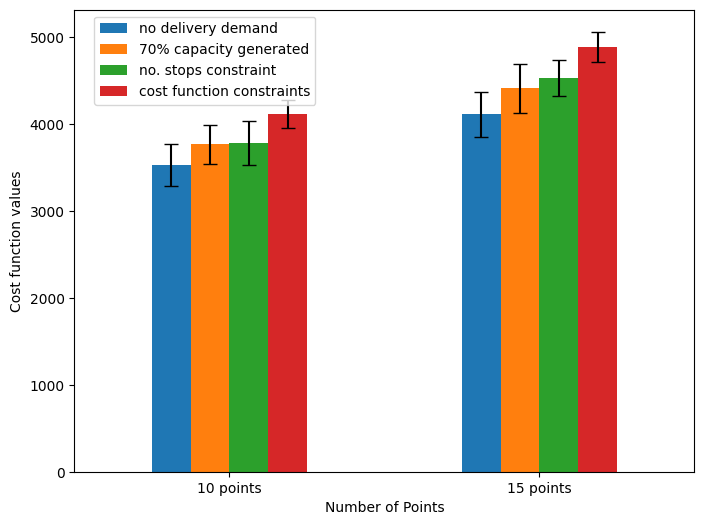

In [100]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

data = {
    'number of points': ['10 points', '15 points'],
    'no delivery demand': [3524.9700000000003,4108.174999999999],
    '70% capacity generated': [3764.5150000000003, 4411.174999999998],
    'no. stops constraint': [3776.1150000000002,4523.004],
    'cost function constraints': [4114.945000000001,4887.166666666551]
}

df = pd.DataFrame(data)


error_data = {
    'no delivery demand': [238.9848654270052, 255.17223819805957],
    '70% capacity generated': [225.35364966745104, 281.63753553828116],
    'no. stops constraint': [254.660279790081, 208.266518452481051],
    'cost function constraints': [160.56121978625325, 172.29610447044072]
}

errors_df = pd.DataFrame(error_data)

fig, ax = plt.subplots(figsize=(8, 6))
plt.grid()

df_plot = df.set_index(['number of points'])

df_plot.plot(kind='bar', yerr=errors_df.values.T, ax=ax, capsize=5)

ax.set_ylabel('Cost function values')
ax.set_xlabel('Number of Points')

plt.legend(title='', loc='upper right', bbox_to_anchor=(0.4, 1))

plt.xticks(rotation=0)

plt.show()